# **Decision Trees**
This analysis predicts a bank churn scenario using decision tree classification algorithms, comparing performance using early stopping criteria and random forests.

# Pre-processing


In [1]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    print("ROC Score:", roc_auc_score(y_test, predictions))
    print("Accuracy Score", accuracy_score(y_test, predictions))


np.random.seed(0)

# Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/C2_W5_Datasets/bank_churn_data_raw.csv", index_col=0)


# Data Exploration


In [2]:
#see a sample of the data
df.sample(5)

,CreditScore,Location,Male,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4007,619.0,1.0,0.0,33.0,2.0,0.0,2.0,1.0,1.0,64746.02,0
4616,699.0,2.0,0.0,72.0,6.0,131082.57,NaN,0.0,1.0,?,0
381,575.0,0.0,0.0,45.0,2.0,152522.47,1.0,0.0,NaN,121210.09,0
302,?,1.0,0.0,40.0,5.0,139542.82,1.0,1.0,0.0,54372.37,0
4205,587.0,2.0,0.0,30.0,4.0,76914.21,1.0,1.0,1.0,126517.97,0


In [3]:
#see number of features and observations and column data types
print('Data Frame Shape:',df.shape)
print(df.info())

Data Frame Shape: (5034, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 5034 entries, 0 to 5033
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CreditScore      4935 non-null   object
 1   Location         4937 non-null   object
 2   Male             4938 non-null   object
 3   Age              4934 non-null   object
 4   Tenure           4934 non-null   object
 5   Balance          4936 non-null   object
 6   NumOfProducts    4937 non-null   object
 7   HasCrCard        4940 non-null   object
 8   IsActiveMember   4936 non-null   object
 9   EstimatedSalary  4938 non-null   object
 10  Exited           5034 non-null   int64 
dtypes: int64(1), object(10)
memory usage: 471.9+ KB
None


CreditScore   ['?']
Location   ['?']
Male   ['?']
Age   ['?']
Tenure   ['?']
Balance   ['?']
NumOfProducts   ['?']
HasCrCard   ['?']
IsActiveMember   ['?']
EstimatedSalary   ['?']


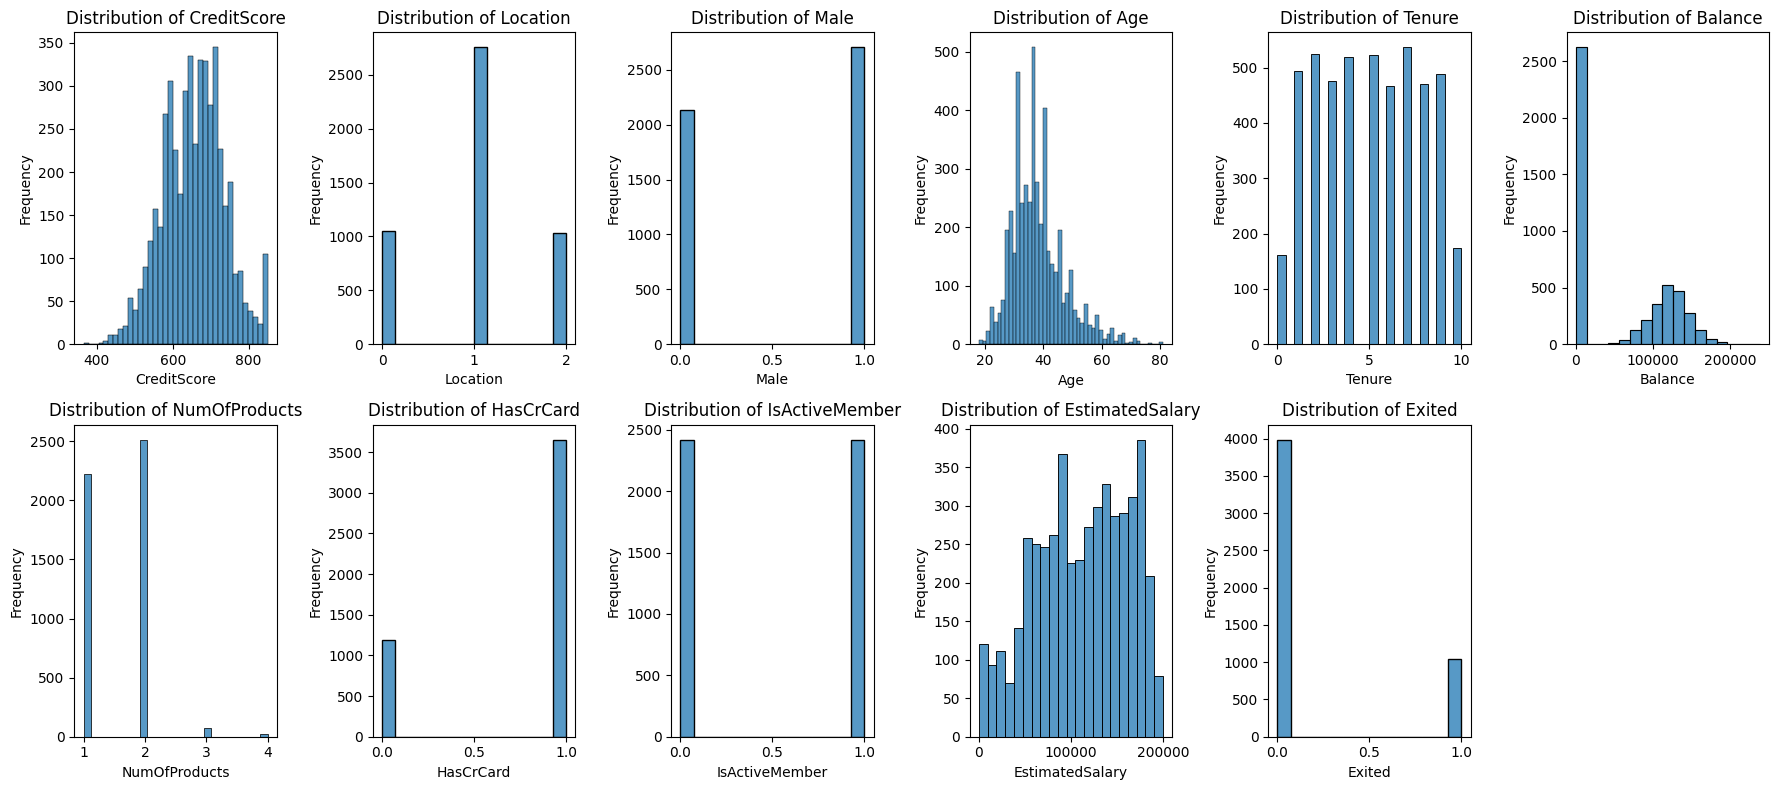

In [4]:
#why are they object columns when should be float

#def function to determine if the column value can be converted into a float
def is_float(val):
        try:
            float(val)
            return True
        except (ValueError, TypeError):
            return False

#for float values, plot the distribution to see if we can estimate missing values
fig,axes = plt.subplots(2, 6, figsize=(18,8))
axes = axes.flatten()  # flatten to iterate easily
idx = 0
for column in df.columns:
    if df[column].dtype == 'object':
        non_float_values = [val for val in df[column].unique() if is_float(val)==False]
        float_values = [val for val in df[column].unique() if is_float(val)==True]
        if non_float_values:
            print(column,' ',non_float_values)

    if float_values:
        numeric_data = pd.to_numeric(df[column], errors='coerce').dropna()  # convert to numeric, drop ? and na
    if len(numeric_data) > 0:
        sns.histplot(numeric_data, ax=axes[idx])
        axes[idx].set_title(f'Distribution of {column}')
        axes[idx].set_xlabel(column)
        axes[idx].set_ylabel('Frequency')
        plt.tight_layout()
        idx += 1
#delete any empty axis
for j in range(idx, len(axes)):
    fig.delaxes(axes[j])


In [5]:
#check for imbalance in the dataset
df['Exited'].value_counts(normalize=True)
#significantly skewed towards 0

,proportion
Exited,
0,0.791816
1,0.208184


# Transformations

In [6]:
#impute the ? for continuous variables: CreditScore, Age, Balance and Estimated Salary and Tenure using the median value
continuous_cols = ['CreditScore', 'Age', 'Balance','Tenure','EstimatedSalary']
for col in continuous_cols:
    df[col] = df[col].replace('?',pd.NA)
    df[col] = pd.to_numeric(df[col], errors='coerce')
    median_val = df[col].median()
    df[col]=df[col].fillna(median_val)


In [7]:
#impute the ? for binary variables using the mode
category_cols = ['Location', 'Male', 'NumOfProducts','HasCrCard','IsActiveMember']
for col in category_cols:
    df[col] = df[col].replace('?',pd.NA)
    df[col] = pd.to_numeric(df[col], errors='coerce')
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)


In [8]:
#see what the dataset looks like
df.describe().round()

,CreditScore,Location,Male,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,5034.0,5034.0,5034.0,5034.0,5034.0,5034.0,5034.0,5034.0,5034.0,5034.0,5034.0
mean,656.0,1.0,1.0,38.0,5.0,53468.0,2.0,1.0,1.0,111943.0,0.0
std,79.0,1.0,0.0,9.0,3.0,62648.0,1.0,0.0,0.0,49112.0,0.0
min,365.0,0.0,0.0,18.0,0.0,0.0,1.0,0.0,0.0,107.0,0.0
25%,598.0,1.0,0.0,32.0,3.0,0.0,1.0,1.0,0.0,74850.0,0.0
50%,659.0,1.0,1.0,37.0,5.0,0.0,2.0,1.0,1.0,115934.0,0.0
75%,708.0,1.0,1.0,42.0,7.0,118668.0,2.0,1.0,1.0,152828.0,0.0
max,850.0,2.0,1.0,81.0,10.0,238388.0,4.0,1.0,1.0,199953.0,1.0


In [9]:
#check transformations have worked correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5034 entries, 0 to 5033
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      5034 non-null   float64
 1   Location         5034 non-null   float64
 2   Male             5034 non-null   float64
 3   Age              5034 non-null   float64
 4   Tenure           5034 non-null   float64
 5   Balance          5034 non-null   float64
 6   NumOfProducts    5034 non-null   float64
 7   HasCrCard        5034 non-null   float64
 8   IsActiveMember   5034 non-null   float64
 9   EstimatedSalary  5034 non-null   float64
 10  Exited           5034 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 471.9 KB


Text(0.5, 1.0, 'Feature Correlation Matrix')

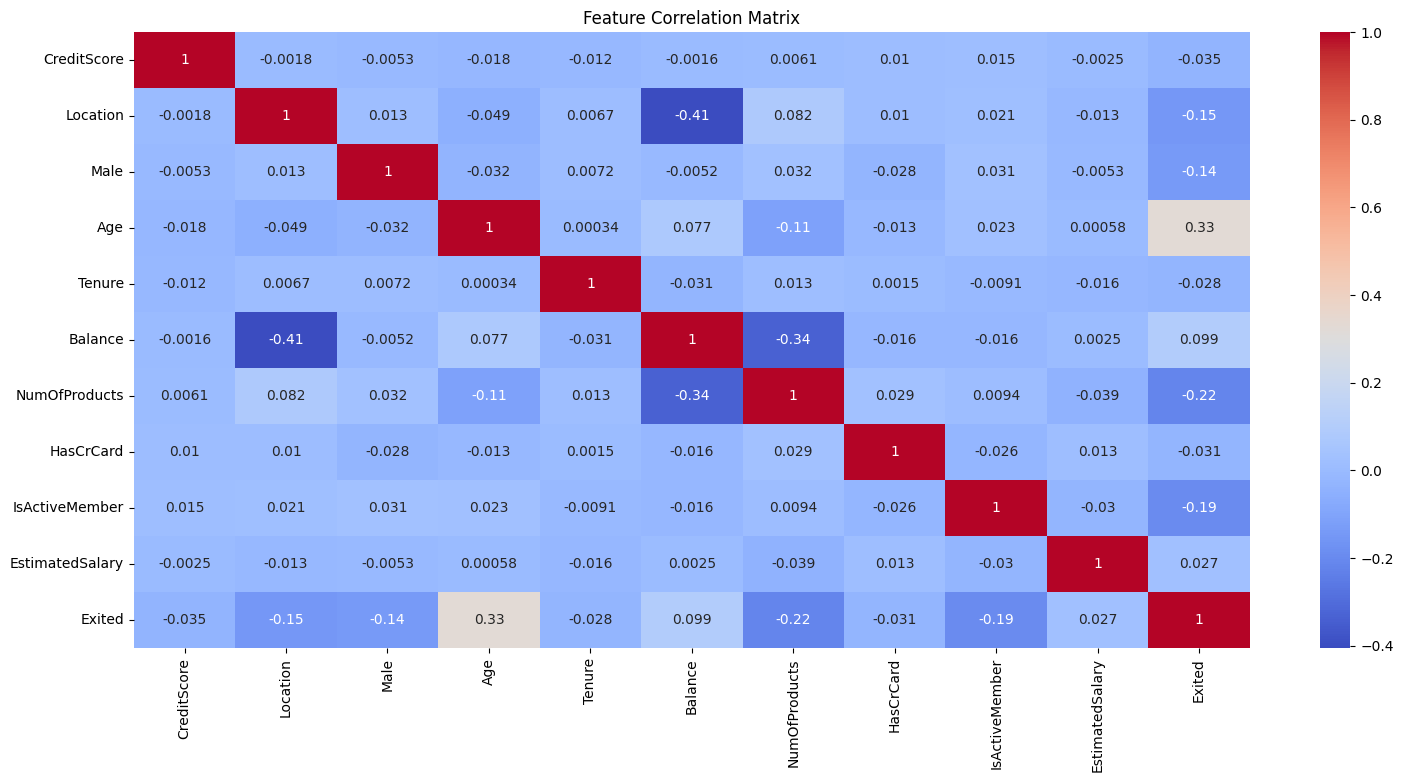

In [10]:
#look at correlation
plt.figure(figsize=(18,8))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')
plt.title('Feature Correlation Matrix')
#no highly correlated features

In [11]:
#assign the X and y variables
X = df.drop(columns='Exited',axis=1)
y = df['Exited']

In [12]:
# technically a lot of these columns are not continuous variables,
# i.e. a location of 2 has no signifiance or relationship between location = 1. Therefore need to one hot encode the categorical variables
X_encoded = X.copy()
enc = OneHotEncoder(drop='first',sparse_output=False, handle_unknown='ignore')
X_encoded.drop(category_cols,axis=1,inplace=True)
X_encoded_features = enc.fit_transform(X[category_cols])
encoded_feature_names = enc.get_feature_names_out(category_cols)

#replace columns with one hot encoded columns
X_encoded.loc[:,encoded_feature_names] = X_encoded_features
X_encoded.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Location_1.0,Location_2.0,Male_1.0,NumOfProducts_2.0,NumOfProducts_3.0,NumOfProducts_4.0,HasCrCard_1.0,IsActiveMember_1.0
0,585.0,53.0,2.0,0.00,91830.750,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
1,606.0,24.0,2.0,0.00,115933.755,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,633.0,44.0,1.0,118907.60,47777.150,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,602.0,40.0,2.0,149961.99,82696.840,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,645.0,31.0,4.0,132351.29,151887.160,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [13]:
#split dataset in to train and test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, random_state=42)

# Basic Decision Tree Models

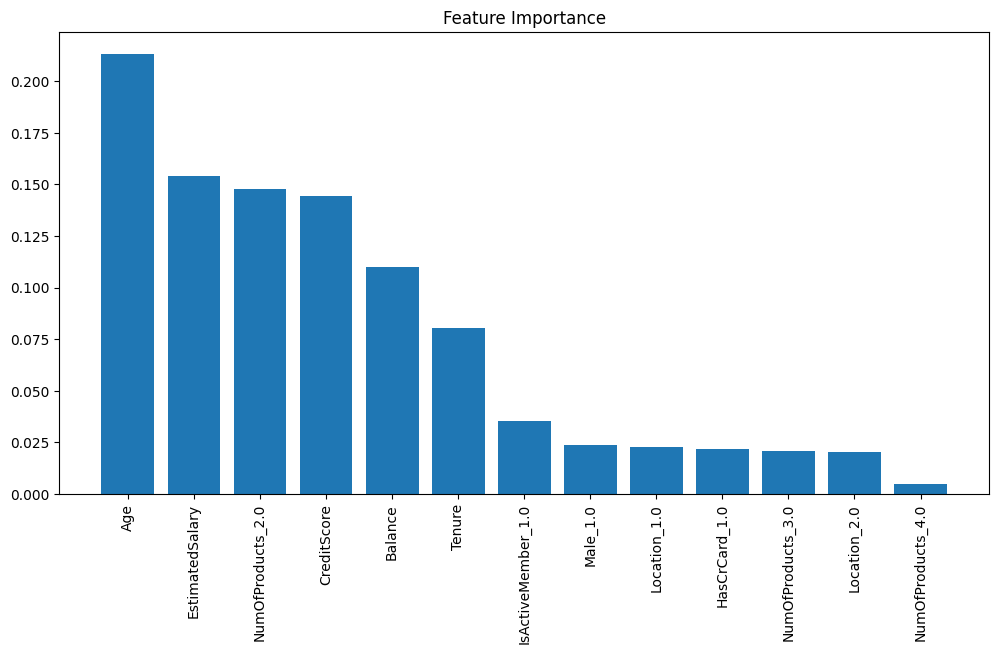

ROC Score: 0.6692322970181664
Accuracy Score 0.7842488418266049


In [14]:
#building the decision tree model
tree_classifier = DecisionTreeClassifier(criterion='gini',random_state=42)
tree_classifier.fit(X_train, y_train)

#model evaluation
y_pred_gini = tree_classifier.predict(X_test)

#visualise the importance of features
importances = tree_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances[indices],align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.show()

#evluate the model
evaluate_model(tree_classifier,X_test,y_test)

In [15]:
#need to convert target to a string to be able to plot the decision tree
target_names= [str(val) for val in y.unique()]

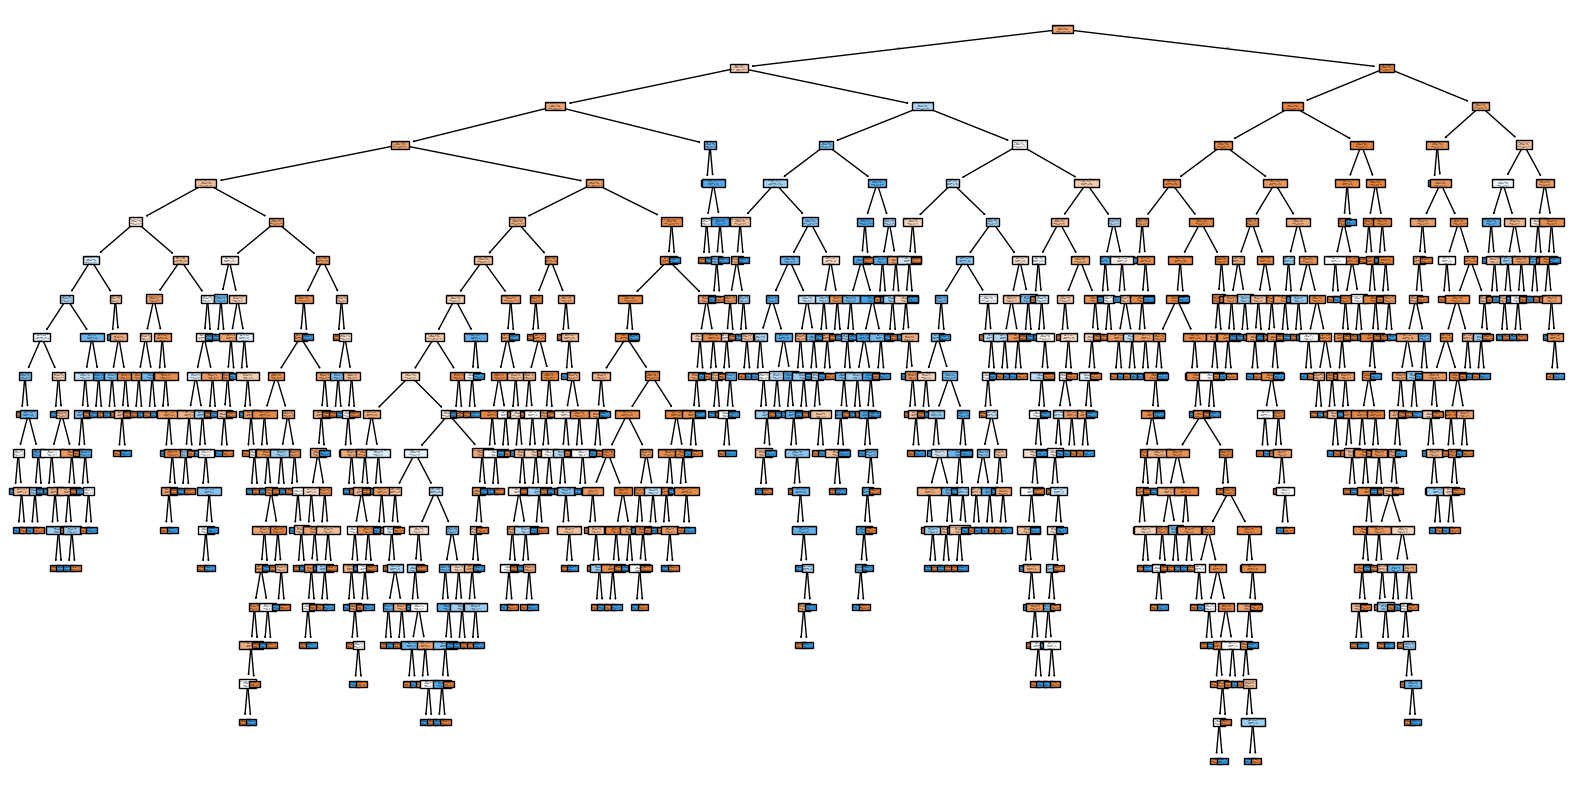

In [16]:
# Visualise the tree
plt.figure(figsize=(20,10))
plot_tree(tree_classifier, feature_names=list(X_train.columns), class_names=target_names , filled=True)
plt.show()

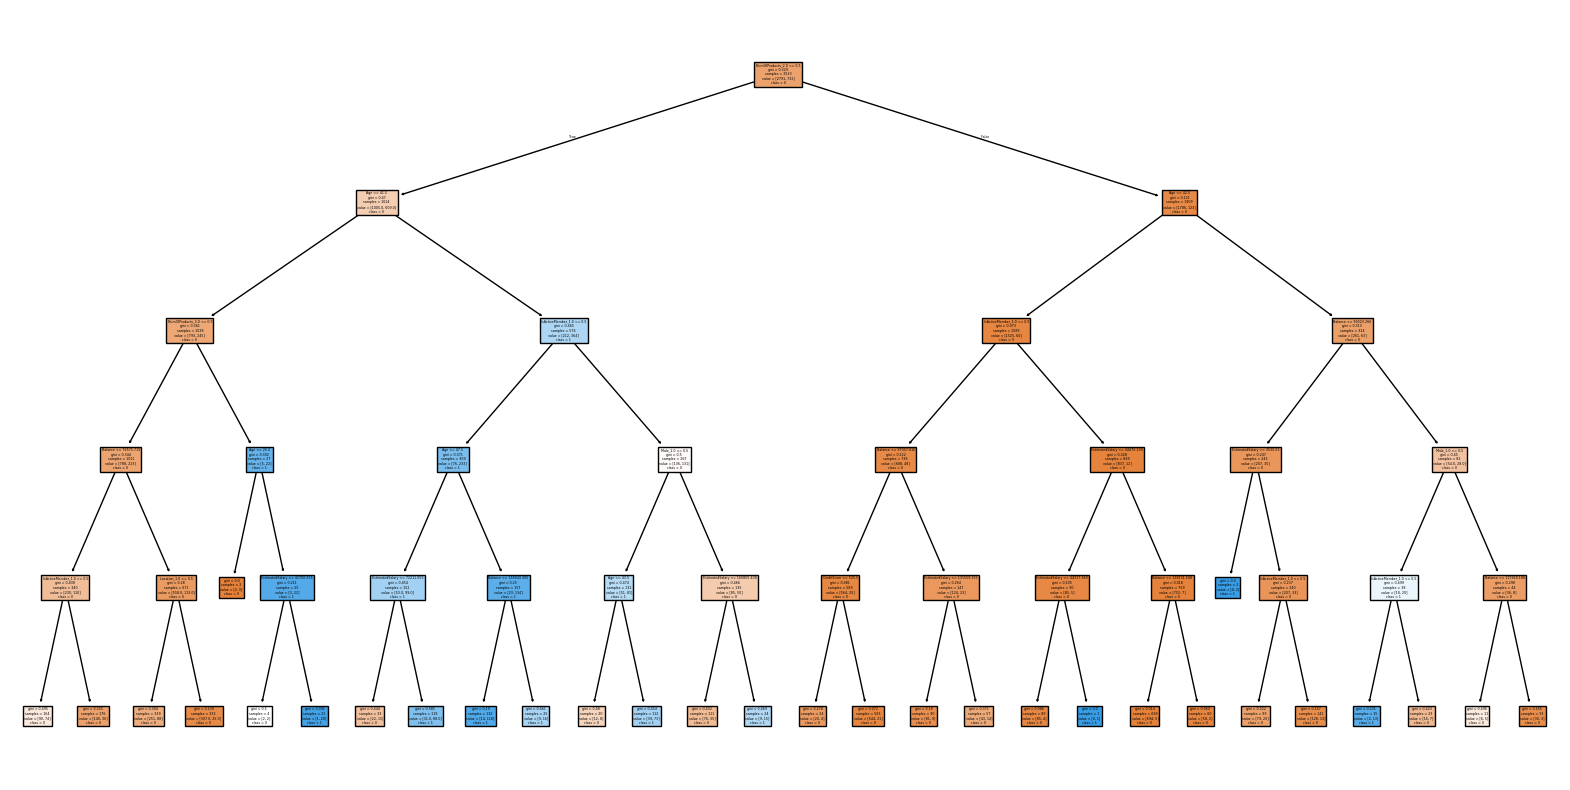

In [17]:
# Need to implement max_depth and min_samples_leaf as the decision tree above will suffer from overfitting without
# 1. max_depth
max_depth_tree = DecisionTreeClassifier(criterion='gini',max_depth=5,random_state=42)
max_depth_tree.fit(X_train,y_train)
y_pred_max_depth = max_depth_tree.predict(X_test)
#plot decision tree
plt.figure(figsize=(20,10))
plot_tree(max_depth_tree, feature_names=list(X_train.columns), class_names=target_names, filled=True)
plt.show()

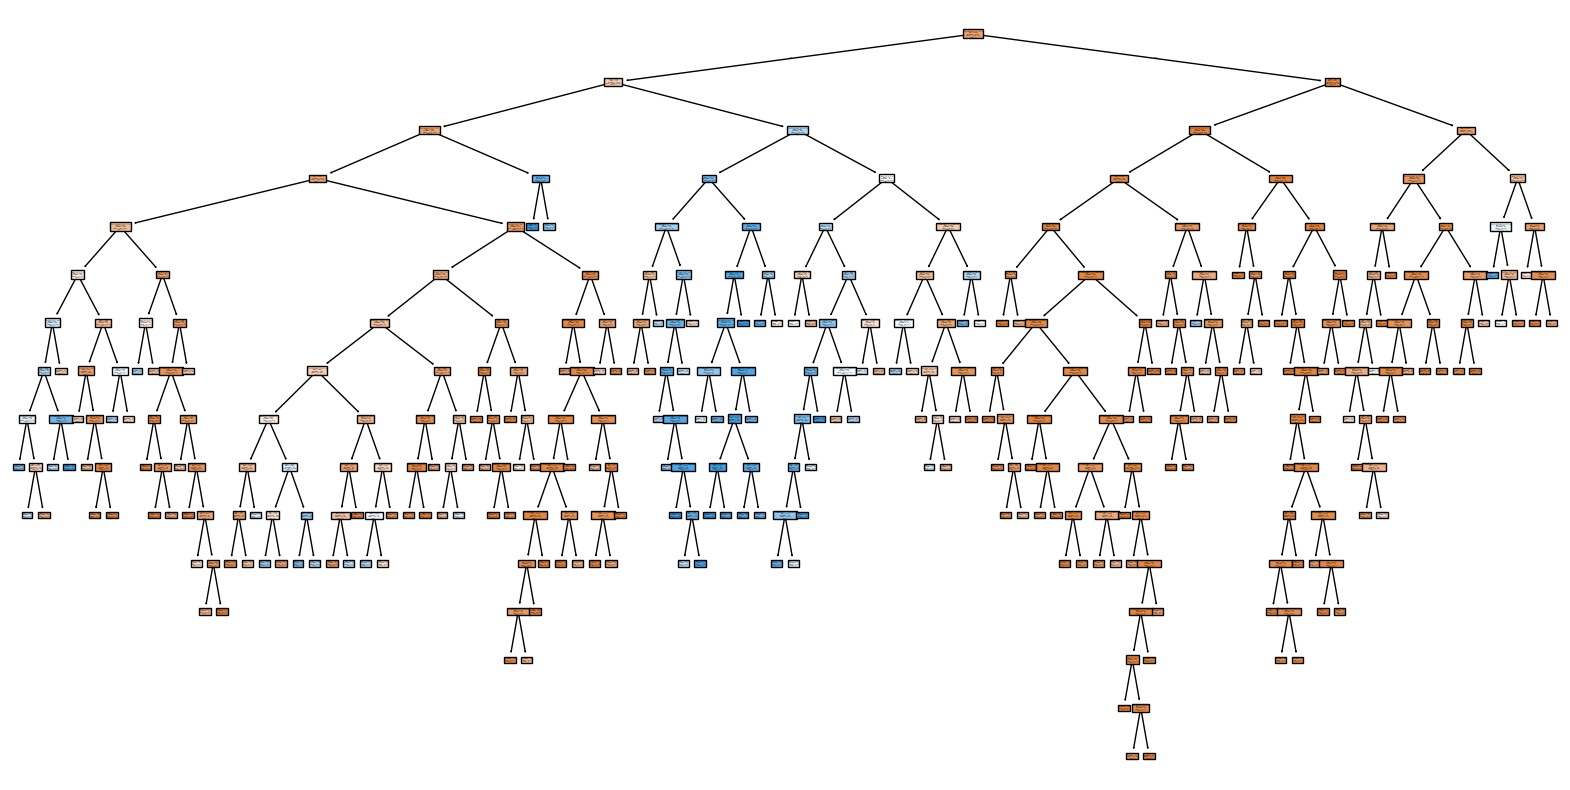

In [18]:
# 2. min leaf samples
min_num_tree = DecisionTreeClassifier(criterion='gini',min_samples_leaf=10,random_state=42)
min_num_tree.fit(X_train,y_train)
y_pred_min_num = min_num_tree.predict(X_test)
#plot decision tree
plt.figure(figsize=(20,10))
plot_tree(min_num_tree, feature_names=list(X_train.columns), class_names=target_names, filled=True)
plt.show()

In [19]:
#compare performance of different models
simple_tree_acc = accuracy_score(y_test, y_pred_gini)
max_depth_tree_acc = accuracy_score(y_test, y_pred_max_depth)
min_num_tree_acc = accuracy_score(y_test, y_pred_min_num)

print(f"Simple Decision Tree: {simple_tree_acc:.2f}")
print(f"Max Depth Tree: {max_depth_tree_acc:.2f}")
print(f"Min Number of samples Tree: {min_num_tree_acc:.2f}")

#min number of samples and max depth perform significantly better on test data as it better generalises the data

Simple Decision Tree: 0.78
Max Depth Tree: 0.84
Min Number of samples Tree: 0.83


# Ensemble Methods and Their Comparison

In [20]:
#train and evaluate a random forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
random_forest_pred = random_forest.predict(X_test)

In [21]:
# create a random forest using early stopping criteria:
# 1. max_depth:
max_depth_tree_random = RandomForestClassifier(n_estimators=100,max_depth=5,random_state=42)
max_depth_tree_random.fit(X_train,y_train)
y_pred_max_depth_random = max_depth_tree_random.predict(X_test)

# 2. minimum leaf samples:
min_num_tree_random =  RandomForestClassifier(n_estimators=100,min_samples_leaf=10,random_state=42)
min_num_tree_random.fit(X_train,y_train)
y_pred_min_num_random = min_num_tree_random.predict(X_test)

In [22]:
#Compare Random Forest against the simple Decision Tree
random_forest_acc = accuracy_score(y_test, random_forest_pred)
max_depth_rf_acc = accuracy_score(y_test, y_pred_max_depth_random)
min_num_rf_acc = accuracy_score(y_test, y_pred_min_num_random)


print(f"Simple Decision Tree: {simple_tree_acc:.2f}")
print(f"Random Forest: {random_forest_acc:.2f}", end='\n\n')

print(f"Max Depth Tree: {max_depth_tree_acc:.2f}")
print(f"Max Depth Random Forest: {max_depth_rf_acc:.2f}", end= '\n\n')

print(f"Min Number of samples Tree: {min_num_tree_acc:.2f}")
print(f"Min Number of samples Random Forest: {min_num_rf_acc:.2f}")


Simple Decision Tree: 0.78
Random Forest: 0.84

Max Depth Tree: 0.84
Max Depth Random Forest: 0.84

Min Number of samples Tree: 0.83
Min Number of samples Random Forest: 0.85


###Compiling all the models, there is not a significant improvement when using random forest in this particular example, however the accuracy was already fairly high when using early stopping criteria. The most accurate model is the random forest using 100 estimators and a minimum leaf sample size of 10, obtaining an accuracy of 0.85